# Faster R-CNN for Object Tracking

In this notebook we will leverage a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) neural network in order to perform the object tracking task.
The architecture of a Faster R-CNN is characterized by the **Region Proposal Network**, where it slides a small network over the feature map extracted by the backbone in a sliding window fashion, and at each window location it generates multiple potential bounding box (named *anchors*): for each one of them, the network predicts whether the anchor contains an object or not and the coordinates for the bounding box refinement. These outputs are then taken as input to a *Region of Interest Pooling* layer, which converts each proposal into a fixed-size feature vector (this allows to handle varying-sized objects). The ROI Pooling layer's output then goes through a final fully connected layer which performs the actual detection, which is composed by two output branches: a *classification* branch and a *bounding box regressor* which further refines the coordinates.

In our case, we use a [Faster R-CNN with MobileNetV3](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn.html) as backbone, which is specifically designed for mobile applications optmizing layer configurations, block structures and with an adaptive kernel size selection. This backbone can guarantee faster inference compared to larger bakcbones like ResNet keeping a lower memory footprint and a good balance between speed and accuracy. Moreover, the pre-trained neural network include a **Feature Pyramid Network** (FPN) which is crucial for handling objects at different scales: it creates a multi-scale feature pyramid from a single scale input, creating a structure efficient for detecting small objects at higher resolutions (lower levels), and bigger objects at lower resolutions (higher levels).

## Implementation

We first download dependencies that aren't available by default in some well known environments like *Google's Colab* or *Kaggle*:

In [3]:
!pip install roboflow torchmetrics kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


Then we perform the necessary import for this project, which mainly leverages *PyTorch* framework and the *PyTorch Vision* module.

In [6]:
import numpy as np
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from roboflow import Roboflow
from tqdm import tqdm
from matplotlib import pyplot as plt
import glob as glob
import kagglehub
from base64 import b64encode
from IPython.display import HTML
import yaml

In order to make both training and inference faster, we enable GPU acceleration if the envorinment has a `cuda` device.

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print("We use the following device: ", device)

We use the following device:  cuda


### Dataset Download

In the following section, we download and create a `torch.utils.data.Dataset` for the Traffic Signs domain. This is required in order to make the training and validation phases faster and standardized for PyTorch.

Firstly we download some testing videos upon which we will perform object tracking at the end of this notebook.

In [8]:
traffic_lights_video_path = kagglehub.dataset_download('matteoiorio/traffic-lights-video')

Then we download the traffic signs dataset which contains 10.000 images with 29 different classes:
- Road narrows on right
- 50 mph speed limit
- Attention Please
- Beware of children
- CYCLE ROUTE AHEAD WARNING
- Dangerous Left Curve Ahead
- Dangerous Rright Curve Ahead
- End of all speed and passing limits
- Give Way
- Go Straight or Turn Right
- Go straight or turn left
- Keep-Left
- Keep-Right
- Left Zig Zag Traffic
- No Entry
- No_Over_Taking
- Overtaking by trucks is prohibited
- Pedestrian Crossing
- Round-About
- Slippery Road Ahead
- Speed Limit 20 KMPh
- Speed Limit 30 KMPh
- Stop_Sign
- Straight Ahead Only
- Traffic_signal
- Truck traffic is prohibited
- Turn left ahead
- Turn right ahead
- Uneven Road


In [9]:
rf = Roboflow(api_key="Ex8Yj8EiaKSeCDoNeUms")
project = rf.workspace("selfdriving-car-qtywx").project("self-driving-cars-lfjou")
version = project.version(4)
traffic_signs = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Cars-4 in yolov11:: 100%|██████████| 9950/9950 [00:01<00:00, 8826.95it/s] 


Now we define a `TrafficDataset` object, which purpose is to convert a yolo-optimized dataset into a format suitable for our pre-trained Faster R-CNN. Due to the fact that the latter is trained on `COCO-v1` dataset, the expect format of targets must adhere the following structure:

- `boxes`
- `labels`
- `image_id`
- `area`
- `iscrowd`

even if we are interested in the first two parameters only, we compute `area` and set to a zero-tensor the value `iscrowd`.
In order to avoid exceptions during training or validation when given as input images without bounding boxes, we must explicitly return an empty structure when this case occurs. Finally, before packing the strucutre, we convert bounding boxes yolo-based coordinates (relative coordinates), into absolute coordinates of type `[xyxy]`.

In [10]:
class TrafficDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.img_dir = os.path.join(root_dir, split, 'images')
        self.label_dir = os.path.join(root_dir, split, 'labels')

        self.img_files = [d for d in os.listdir(self.img_dir) if d.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        img_w, img_h = image.size

        label_name = '.'.join(img_name.split('.')[:3]) + ".txt"
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []

        if not os.path.exists(label_path):
            raise RuntimeError(f"Label for image {img_path} ({label_path}) does not exists!")

        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)



        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Building targets
        # FasterRCNN needs, along with boxes and labels, fields
        # image_id, area, and iscrowd.
        if len(boxes) == 0:
          target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64)
          }
        else:
          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": torch.tensor([idx]),
              "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
              "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
          }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [11]:
base_path = "Self-Driving-Cars-4"

train_path = "train"
valid_path = "valid"
test_path = "test"

We load from the yaml configuration file the class names and the number of classes incremented by one, which represents the *background* class for the pre-trained model.

In [12]:
with open(os.path.join(base_path, "data.yaml")) as f:
    dataset_config = yaml.safe_load(f)
    class_labels = dataset_config["names"]
    NUM_CLASSES = int(dataset_config['nc']) + 1

### Fine Tuning

In this section we will proceed to fine tune and train on our dataset the pre-trained model.

In [25]:
SEED = 1926
NUM_EPOCHS = 30
LR = 0.005
LR_MOMENTUM = 0.9
LR_DECAY_RATE = 0.0005
LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1
BATCH_SIZE = 8

torch.manual_seed(SEED)

Then we define 

In [18]:
from torchvision.transforms import v2 as T

def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    return T.Compose(transforms)

In [19]:
if not os.path.exists("engine.py") \
    and not os.path.exists('utils.py') \
    and not os.path.exists("coco_utils.py") \
    and not os.path.exists("coco_eval.py") \
    and not os.path.exists("transforms.py"):

    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [20]:
def get_dataloaders():
    train_dataset = TrafficDataset(
        root_dir=base_path,
        split=train_path,
        transform=get_transform(train=True)
    )

    valid_dataset = TrafficDataset(
        root_dir=base_path,
        split=valid_path,
        transform=get_transform(train=False)
    )

    test_dataset = TrafficDataset(
        root_dir=base_path,
        split=test_path,
        transform=get_transform(train=False)
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    return train_dataloader, valid_dataloader, test_dataloader

In [26]:
from engine import train_one_epoch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_d, valid_d, test_d = get_dataloaders()

model = get_model()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=LR_MOMENTUM,
    weight_decay=LR_DECAY_RATE
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=LR_SCHED_STEP_SIZE,
    gamma=LR_SCHED_GAMMA
)
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, train_d, device, epoch, print_freq=10)
    lr_scheduler.step()

print("Training complete!")

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [  0/442]  eta: 0:02:38  lr: 0.000016  loss: 3.1025 (3.1025)  loss_classifier: 2.9112 (2.9112)  loss_box_reg: 0.1035 (0.1035)  loss_objectness: 0.0453 (0.0453)  loss_rpn_box_reg: 0.0425 (0.0425)  time: 0.3579  data: 0.0334  max mem: 1950
Epoch: [0]  [ 10/442]  eta: 0:02:10  lr: 0.000130  loss: 3.1952 (3.2388)  loss_classifier: 2.8434 (2.8290)  loss_box_reg: 0.1971 (0.2837)  loss_objectness: 0.0659 (0.0901)  loss_rpn_box_reg: 0.0318 (0.0360)  time: 0.3017  data: 0.0366  max mem: 1950
Epoch: [0]  [ 20/442]  eta: 0:02:06  lr: 0.000243  loss: 2.8622 (2.7196)  loss_classifier: 2.5025 (2.3183)  loss_box_reg: 0.2815 (0.2917)  loss_objectness: 0.0396 (0.0738)  loss_rpn_box_reg: 0.0318 (0.0359)  time: 0.2975  data: 0.0376  max mem: 1950
Epoch: [0]  [ 30/442]  eta: 0:02:02  lr: 0.000356  loss: 1.5653 (2.2149)  loss_classifier: 1.0938 (1.7853)  loss_box_reg: 0.3200 (0.3214)  loss_objectness: 0.0418 (0.0736)  loss_rpn_box_reg: 0.0303 (0.0347)  time: 0.2937  data: 0.0362  max mem: 1950


In [28]:
torch.save(model.state_dict(), "fastrcnn_traffic_aug.pth")

In [29]:
from torchmetrics.detection import MeanAveragePrecision

def evaluate_model(model, dataloader, device):
  metric = MeanAveragePrecision(box_format="xyxy")
  model.eval()

  with torch.no_grad():
    for images, targets in tqdm(dataloader, desc="Evaluating model..."):
      images = [img.to(device) for img in images]
      predictions = model(images)

      preds = []
      trgts = []

      for pred, target in zip(predictions, targets):
        preds.append({
            'boxes': pred['boxes'].cpu(),
            'scores': pred['scores'].cpu(),
            'labels': pred['labels'].cpu(),
        })

        trgts.append({
            'boxes': target['boxes'].cpu(),
            'labels': target['labels'].cpu(),
        })

      metric.update(preds, trgts)

  results = metric.compute()

  print("\nDetection Metrics:")
  print(f"mAP (all classes): {results['map'].item():.4f}")
  print(f"mAP@.50 IoU: {results['map_50'].item():.4f}")
  print(f"mAP@.75 IoU: {results['map_75'].item():.4f}")
  print(f"mAP (small objects): {results['map_small'].item():.4f}")
  print(f"mAP (medium objects): {results['map_medium'].item():.4f}")
  print(f"mAP (large objects): {results['map_large'].item():.4f}")
  print(f"Average Recall (AR@1): {results['mar_1'].item():.4f}")
  print(f"Average Recall (AR@10): {results['mar_10'].item():.4f}")
  print(f"Average Recall (AR@100): {results['mar_100'].item():.4f}")

  return results

In [30]:
evaluate_model(model, valid_d, device)

Evaluating model...: 100%|██████████| 101/101 [00:16<00:00,  6.07it/s]



Detection Metrics:
mAP (all classes): 0.6074
mAP@.50 IoU: 0.7588
mAP@.75 IoU: 0.7069
mAP (small objects): 0.1527
mAP (medium objects): 0.5714
mAP (large objects): 0.6910
Average Recall (AR@1): 0.6636
Average Recall (AR@10): 0.6788
Average Recall (AR@100): 0.6788


{'map': tensor(0.6074),
 'map_50': tensor(0.7588),
 'map_75': tensor(0.7069),
 'map_small': tensor(0.1527),
 'map_medium': tensor(0.5714),
 'map_large': tensor(0.6910),
 'mar_1': tensor(0.6636),
 'mar_10': tensor(0.6788),
 'mar_100': tensor(0.6788),
 'mar_small': tensor(0.2088),
 'mar_medium': tensor(0.6644),
 'mar_large': tensor(0.7503),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        dtype=torch.int32)}

In [25]:
def load_model(weights_path: str, device):
  model = get_model()
  if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path))
    print(f"Model successfully loaded from {weights_path}")
  model.to(device)
  return model

model = load_model("fastrcnn_traffic.pth", device)

Model successfully loaded from fastrcnn_traffic.pth


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [31]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import math


def visualise_detections(model, base_path: str, images: list[str],
                         device, score_threshold=0.5, images_per_row=4,
                         figsize=(20, 1600), bbox_color="red"):

    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)

    plt.figure()

    transform = get_transform(train=False)

    model.eval()
    with torch.no_grad():
      for idx, img_path in enumerate(images):
        image = read_image(os.path.join(base_path, img_path))
        x = transform(image)
        x = x[:3, ...].to(device)

        predictions = model([x, ])
        pred = predictions[0]

        print(pred)

        mask = pred["scores"] > score_threshold
        filtered_boxes = pred['boxes'][mask].long()
        filtered_labels = pred['labels'][mask]
        filtered_scores = pred['scores'][mask]

        label_texts = [
            f"{class_labels[label.item()]} : {score:.2f}"
            for label, score in zip(filtered_labels, filtered_scores)
        ]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]

        if len(filtered_boxes) > 0:
          output_image = draw_bounding_boxes(
              image,
              filtered_boxes,
              label_texts,
              colors=bbox_color,
              width=5,
              font_size=2
          )
        else:
          output_image = image

        plt.imshow(output_image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()


{'boxes': tensor([[173.8372,  53.8514, 256.8202,  97.8332]], device='cuda:0'), 'labels': tensor([8], device='cuda:0'), 'scores': tensor([0.0576], device='cuda:0')}


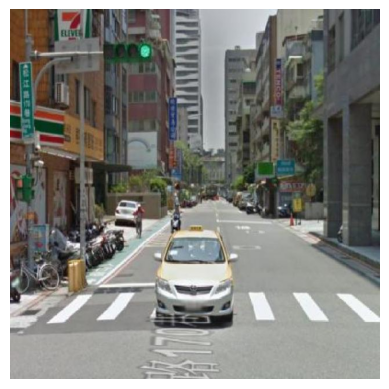

{'boxes': tensor([[ 99.3672,   7.8729, 589.9396, 595.7802],
        [ 96.6542,  31.0598, 558.5999, 572.5390]], device='cuda:0'), 'labels': tensor([14,  3], device='cuda:0'), 'scores': tensor([0.9919, 0.0601], device='cuda:0')}


Argument 'font_size' will be ignored since 'font' is not set.


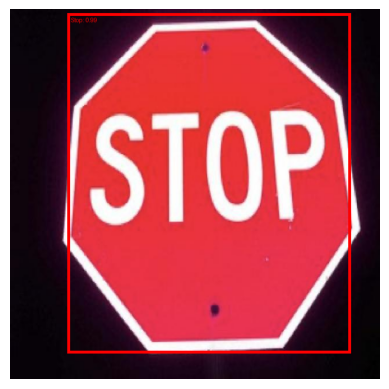

{'boxes': tensor([[274.5162, 112.8468, 517.4539, 459.2544]], device='cuda:0'), 'labels': tensor([3], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}


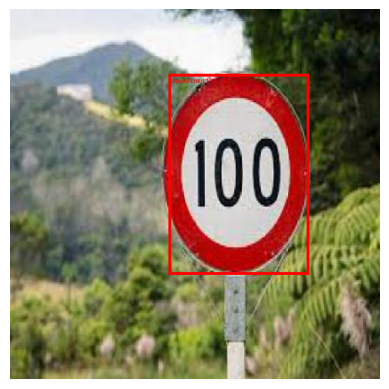

{'boxes': tensor([[307.7708,   0.0000, 603.2762, 483.1983],
        [ 53.1349,  39.3830, 309.7272, 472.2709],
        [ 58.1378,  23.0464, 303.4996, 459.9057],
        [312.3463,   0.0000, 604.6740, 493.0630]], device='cuda:0'), 'labels': tensor([12, 10, 12, 10], device='cuda:0'), 'scores': tensor([0.9981, 0.1199, 0.0891, 0.0675], device='cuda:0')}


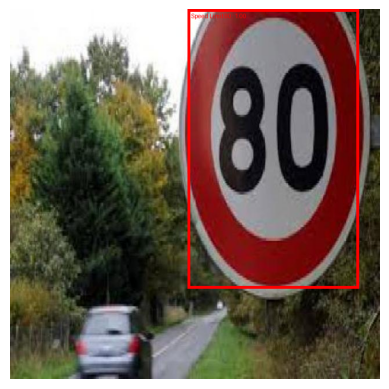

{'boxes': tensor([[169.8747, 174.8103, 516.8380, 529.9736],
        [176.7348, 186.4545, 514.9077, 539.7039]], device='cuda:0'), 'labels': tensor([ 6, 10], device='cuda:0'), 'scores': tensor([0.8065, 0.6992], device='cuda:0')}


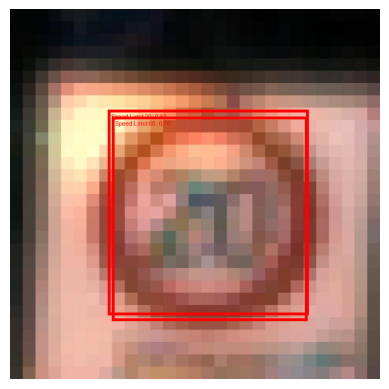

{'boxes': tensor([[234.5797, 227.7633, 314.0913, 293.7641],
        [234.8461, 231.1672, 316.1969, 292.9536],
        [377.2140, 226.4516, 435.8099, 297.8885]], device='cuda:0'), 'labels': tensor([12, 13, 12], device='cuda:0'), 'scores': tensor([0.9443, 0.1176, 0.0632], device='cuda:0')}


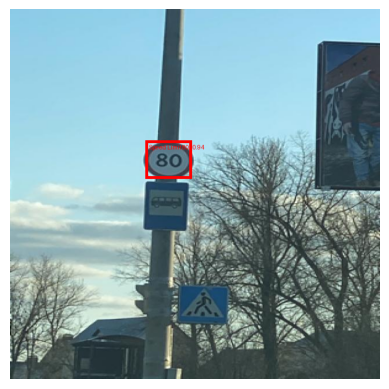

{'boxes': tensor([[268.4416, 313.7632, 312.7282, 353.3607],
        [268.0427, 315.5680, 314.1306, 353.6433],
        [233.9608, 321.4760, 274.1797, 349.2180]], device='cuda:0'), 'labels': tensor([12,  3,  3], device='cuda:0'), 'scores': tensor([0.8819, 0.2068, 0.0631], device='cuda:0')}


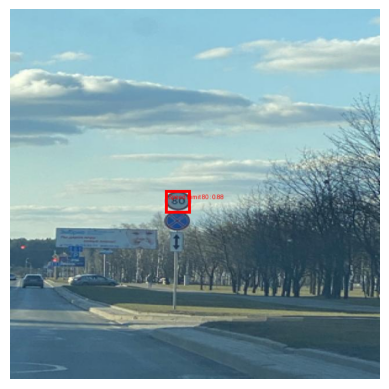

{'boxes': tensor([[178.3430, 134.6281, 535.0643, 512.8236],
        [176.5612, 127.1007, 513.5164, 513.0109]], device='cuda:0'), 'labels': tensor([ 5, 10], device='cuda:0'), 'scores': tensor([0.9923, 0.0700], device='cuda:0')}


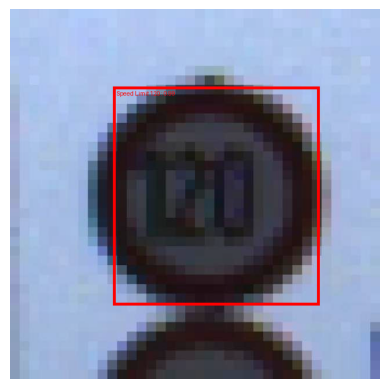

{'boxes': tensor([[167.6095, 130.3978, 522.8945, 510.9724],
        [169.6422, 140.5105, 518.6953, 495.9525],
        [161.5694, 129.4777, 519.4312, 498.8271],
        [156.7186, 126.3249, 529.7379, 508.8724],
        [169.4415, 123.0050, 514.5618, 504.2794],
        [168.2832, 136.2671, 532.9156, 490.1575],
        [179.2790, 117.9870, 519.4666, 490.6193],
        [164.8868, 134.1528, 532.2048, 503.6419]], device='cuda:0'), 'labels': tensor([11, 10,  9,  3,  7,  5,  8, 12], device='cuda:0'), 'scores': tensor([0.8743, 0.1506, 0.1425, 0.1175, 0.0718, 0.0702, 0.0515, 0.0509],
       device='cuda:0')}


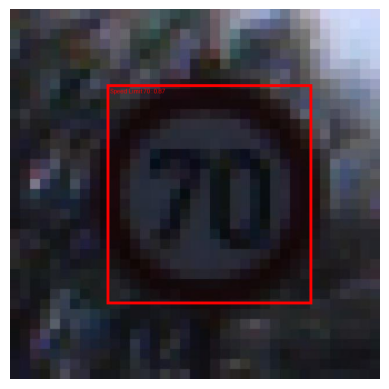

{'boxes': tensor([[146.9292, 109.2683, 529.0261, 531.4770]], device='cuda:0'), 'labels': tensor([14], device='cuda:0'), 'scores': tensor([0.9895], device='cuda:0')}


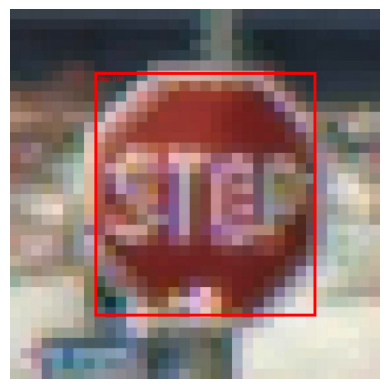

{'boxes': tensor([[534.7147, 249.8786, 572.3597, 284.5639],
        [534.6479, 249.9845, 571.4262, 284.4174],
        [539.0728, 250.9007, 573.1805, 285.9710]], device='cuda:0'), 'labels': tensor([ 5,  8, 11], device='cuda:0'), 'scores': tensor([0.1231, 0.0816, 0.0711], device='cuda:0')}


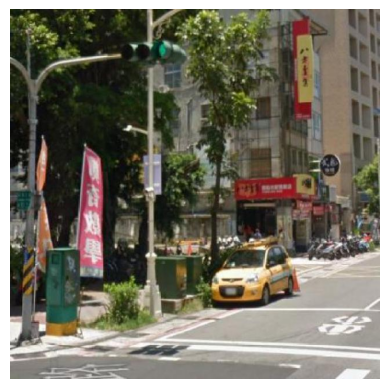

{'boxes': tensor([[281.3585, 149.7285, 430.0451, 256.4357]], device='cuda:0'), 'labels': tensor([8], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}


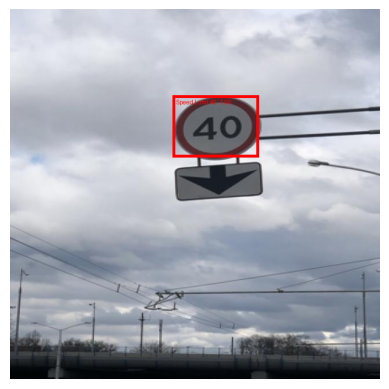

{'boxes': tensor([[137.9903,  64.8354, 339.3249, 204.6982],
        [137.5225,  74.2355, 341.6167, 204.9539],
        [139.8593,  68.5945, 339.0973, 203.9030],
        [141.7273,  68.7128, 346.5471, 203.8680],
        [139.4610,  68.1019, 341.2237, 202.2973],
        [242.0384, 343.7591, 323.1793, 383.6353]], device='cuda:0'), 'labels': tensor([12, 13, 10,  7,  3,  1], device='cuda:0'), 'scores': tensor([0.6811, 0.4274, 0.4262, 0.1814, 0.0781, 0.0686], device='cuda:0')}


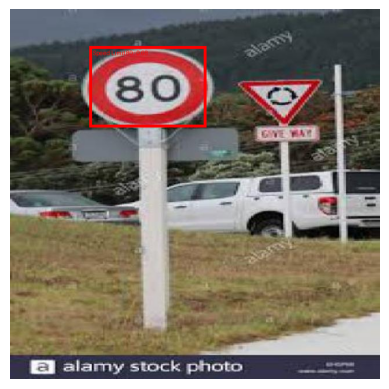

{'boxes': tensor([[ 43.3730,  13.2619, 124.8011, 131.2373],
        [307.4729,  36.8448, 431.6333, 167.9880],
        [203.2129,  55.7100, 296.3599, 187.5940],
        [ 46.8604,  14.2171, 121.8891, 135.3067],
        [ 64.5069, 302.5146, 177.7153, 465.7316]], device='cuda:0'), 'labels': tensor([ 8,  8,  8,  4, 12], device='cuda:0'), 'scores': tensor([0.9820, 0.0755, 0.0736, 0.0633, 0.0535], device='cuda:0')}


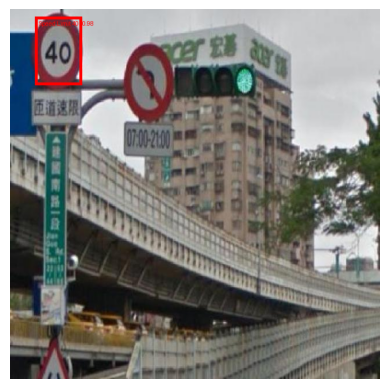

{'boxes': tensor([[164.6148, 240.8023, 264.6760, 326.7871],
        [162.3225, 246.3070, 261.5057, 327.2831],
        [410.6447, 258.1132, 507.3847, 379.9497]], device='cuda:0'), 'labels': tensor([12, 10, 14], device='cuda:0'), 'scores': tensor([0.9933, 0.0908, 0.0830], device='cuda:0')}


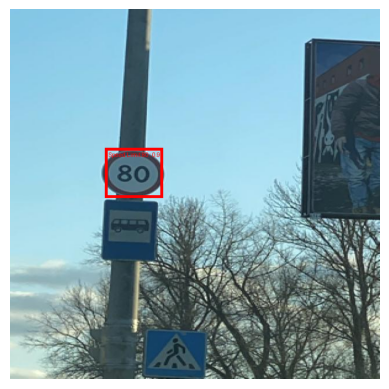

{'boxes': tensor([[125.9629,  83.3007, 556.2711, 557.0971]], device='cuda:0'), 'labels': tensor([7], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}


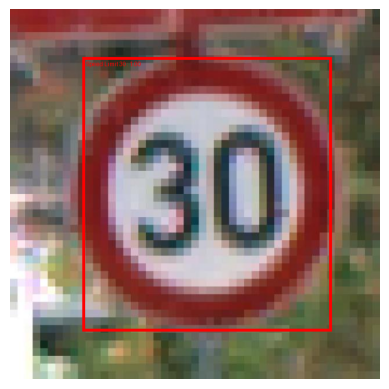

{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


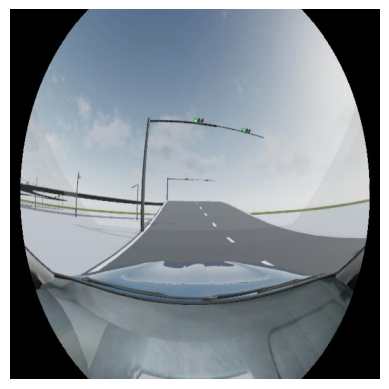

{'boxes': tensor([[252.4378,  51.7632, 390.5504, 275.9649]], device='cuda:0'), 'labels': tensor([9], device='cuda:0'), 'scores': tensor([0.9849], device='cuda:0')}


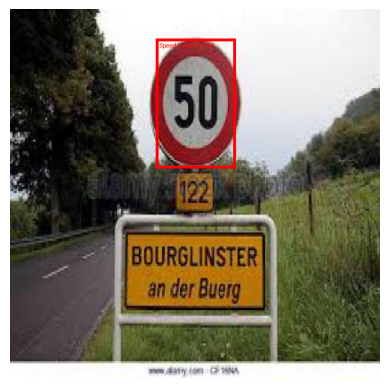

{'boxes': tensor([[131.6216, 106.0575, 515.5800, 520.5486]], device='cuda:0'), 'labels': tensor([6], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}


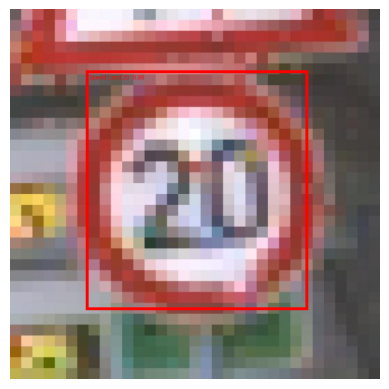

{'boxes': tensor([[304.9528,  72.2548, 379.2525, 110.2168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}


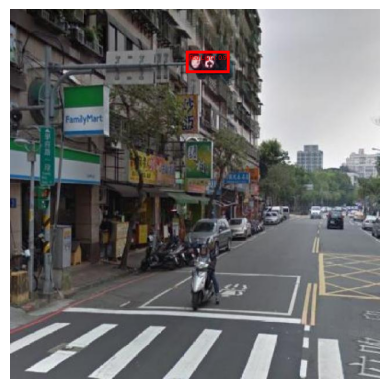

In [32]:
images = os.listdir(os.path.join(base_path, test_path, "images"))[:20]
visualise_detections(model, os.path.join(base_path, "test", "images"), images, device)

## Object Tracking

We use the already defined `compute_iou` in order to compute Intersection Over of the detected bounding boxes.

In [33]:
class FastRCNNDetector:
    def __init__(self, model, device, input_transf=None):
        self.model = model
        self.input_transf = input_transf
        self.device = device

    def detect_single_frame(self, frame, score_threshold = 0.5):
        """
        Args:
            frame: a frame loaded with opencv as a numpy array representing the read frame.
            score_threshold: float representing filtering threshold for yielded predictions.
        """
        self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame) # Need image as Pil Format for FastRCNN Pipeline
            if self.input_transf is not None:
                frame = self.input_transf(frame)
            frame = frame[:3, ...].to(self.device)

            predictions = model([frame, ])
            pred = predictions[0]

            mask = pred['scores'] > score_threshold
            filtered_boxes = pred['boxes'][mask].long()
            filtered_labels = pred['labels'][mask]
            
            return zip(filtered_boxes, filtered_labels)

In [34]:
def compute_iou(bb1: list, bb2: list):
  bb1_x1=bb1[0]
  bb1_y1=bb1[1]
  bb1_x2=bb1[2]
  bb1_y2=bb1[3]

  bb2_x1=bb2[0]
  bb2_y1=bb2[1]
  bb2_x2=bb2[2]
  bb2_y2=bb2[3]

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [35]:
class IOUTracker:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
        self.tracked_objects = {}
        self.next_object_id = 0

    def update(self, detections: list):
        updated_tracked_objects = {}
        assigned_detections = set()

        for obj_id, prev_bbox in self.tracked_objects.items():
            best_iou = 0
            best_det_idx = -1

            for idx, det_bbox in enumerate(detections):
                if idx in assigned_detections:
                    continue
                iou = compute_iou(prev_bbox[:4], det_bbox[:4])
                if iou > best_iou and iou >= self.iou_threshold:
                    best_iou = iou
                    best_det_idx = idx

            if best_det_idx != -1:
                updated_tracked_objects[obj_id] = detections[best_det_idx]
                assigned_detections.add(best_det_idx)

        # Add new detections as new objects
        for idx, det_bbox in enumerate(detections):
            if idx not in assigned_detections:
                updated_tracked_objects[self.next_object_id] = det_bbox
                self.next_object_id += 1

        # Update the tracked objects
        self.tracked_objects = updated_tracked_objects
        return self.tracked_objects

In [36]:
def create_new_video(video_name: str, detector, class_names=None):
    """
    Processes a video to detect and track objects, saving the results as a new video.

    Args:
        video_name (str): The name of the input video file.

    Returns:
        str: The file path of the processed output video.
    """
    # Construct input and output video paths
    input_path = os.path.join(traffic_lights_video_path, video_name)
    output_video_path = video_name.split('.')[0] + "-output.mp4"

    # Open the input video file
    cap = cv2.VideoCapture(input_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Set up the video writer for the output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Initialize the tracker
    tracker = IOUTracker(iou_threshold=0.5)

    # Process each frame of the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform detection on the current frame
        results = detector.detect_single_frame(frame)

        # Extract bounding boxes from the detections
        bbox_list = []
        for bbox, cls in results:
            bbox_list.append([bbox[0], bbox[1], bbox[2], bbox[3], cls])

        # Update tracker with current frame's bounding boxes
        tracked_objects = tracker.update(bbox_list)

        # Draw tracked objects on the frame
        for obj_id, bbox in tracked_objects.items():
            x1, y1, x2, y2 = map(int, bbox[:4])
            class_name = bbox[4]
            if class_names is not None:
                class_name = class_names[class_name]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'Class: {class_name}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    return output_video_path

In [37]:
print(os.listdir(traffic_lights_video_path))
detector = FastRCNNDetector(model, device, get_transform(train=False))
video = create_new_video("traffic_lights_1.mp4", detector, class_labels)
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(""" <video controls><source src="%s" type="video/mp4"></video>""" % data_url)

['traffic_light_3.mp4', 'yolo_best_traffic.pt', 'traffic_lights_2.mp4', 'traffic_lights_red_1.mp4', 'road_video_1.mp4', 'traffic_lights_1.mp4']


In [39]:
%pip install fvcore ptflops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=dcd636c4c7a1021619262414438413d43c9aaaa2aa0cc1f1d305cc3739a16e3b
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=010551c76a0b1634f8917d7fd92136e1f3e718b0d17813932c5a6a4111934699
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Note: you may need to restart the kernel to use updated packages.


---

As a sidenote, we include some interesting characteristics of the network

In [52]:
from ptflops import get_model_complexity_info

model.eval()
macs, params = get_model_complexity_info(model, (3, 800, 800), as_strings=True, print_per_layer_stat=False)
print(f"Model insights: \n- MACs: {macs} (FLOPs: {float(macs.split(' ')[0]) * 2} billions)\n- Params: {params}")

Model insights: 
- MACs: 6.15 GMac (FLOPs: 12.3 billions)
- Params: 18.94 M


The results obtained above are now justified by the size of this Neural Network: with just 18.4 million parameters and 12.3 billions floating point operations per second (as a reference, Faster R-CNN with a ResNet-50 backbone has ~200 GFLOPs), the average precision obtained above is indeed quite good!

As a reference for such metrics, we have referred to the [EfficientDet paper](https://arxiv.org/pdf/1911.09070).

Then, it can be helpful to compute some metrics on inference time, because we recall that this model has been though for being used in edge computing scenarios.

In [53]:
import time

model.eval()
model.to(device)

input_tensor = torch.randn(1, 3, 800, 800).to(device)

def measure_inference_time(model, input_tensor, device, runs=100):
    with torch.no_grad():
        # Warm-up run
        for _ in range(5):
            _ = model(input_tensor)
        
        start_time = time.time()
        for _ in range(runs):
            _ = model(input_tensor)
        end_time = time.time()

        avg_time = (end_time - start_time) / runs
        return avg_time

model.cpu()
input_tensor_cpu = input_tensor.cpu()
cpu_time = measure_inference_time(model, input_tensor_cpu, "cpu")
print(f"Average inference time on CPU: {cpu_time:.4f} seconds")

if torch.cuda.is_available():
    model.to("cuda")
    input_tensor = input_tensor.to("cuda")
    gpu_time = measure_inference_time(model, input_tensor, "cuda")
    print(f"Average inference time on GPU: {gpu_time:.4f} seconds")
else:
    print("CUDA not available, skipping GPU measurement.")

Average inference time on CPU: 0.6748 seconds
Average inference time on GPU: 0.0259 seconds


Considering the above times, we can then determine the **maximum amount** of frames per seconds that theoretically the model can handle

In [54]:
cpu_fps = 1 / cpu_time
gpu_fps = 1 / gpu_time

# Print results
print(f"Maximum FPS on CPU: {cpu_fps:.2f} FPS")
print(f"Maximum FPS on GPU: {gpu_fps:.2f} FPS")

Maximum FPS on CPU: 1.48 FPS
Maximum FPS on GPU: 38.54 FPS
